# Text mining 
## HW 2 MaxEnt on Reuters

We are going to train a Multiclass Maximum Entropy (Softmax Regression) to predict the origin of a document coming from the 20newsgroup dataset.

This exercise is similar to 01-LinearRegression. The difference is that you'll have to implement the algorithm yourself.

For this puprose we'll use PyTorch, and sklearn. Your job is to fill in the missing code into the cells below.

You will find the steps you need to perform in the **Task** section in each cell.

In [319]:
%reset -f
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [320]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder

In [321]:
print('Loading data...')

# Passing none as we want to train over all the data.
newsgroups_train = fetch_20newsgroups(subset='train',
                                      categories=None)

newsgroups_test = fetch_20newsgroups(subset='test',
                                      categories=None)

Loading data...


In [322]:
BATCH_SIZE = 32
MAX_EPOCHS = 20
# Lambda
REG_PARAM = 0.01
# Alpha 
LEARNING_RATE = 1e-02
# Number of features
MAX_WORDS = 10000
# Priting error information after display_step epochs
DISPLAY_STEP = 1
NUM_CLASSES = np.max(newsgroups_train.target) + 1

In [323]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [324]:
print(NUM_CLASSES, 'classes')

print('Vectorizing sequence data...')

vectorizer = TfidfVectorizer(max_features=MAX_WORDS)

tfidf_vectors_train = vectorizer.fit_transform(newsgroups_train.data)
tfidf_vectors_test = vectorizer.transform(newsgroups_test.data)

x_train = tfidf_vectors_train.toarray()
x_test = tfidf_vectors_test.toarray()

y_train = newsgroups_train.target
y_test = newsgroups_test.target

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

20 classes
Vectorizing sequence data...
x_train shape: (11314, 10000)
y_train shape: (11314,)
x_test shape: (7532, 10000)
y_test shape: (7532,)


In [325]:
class TwentyNewsGroupsDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x)
        self.y = torch.from_numpy(y)

        assert len(self.x) == len(self.y)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = TwentyNewsGroupsDataset(x_train, y_train) 
test_dataset = TwentyNewsGroupsDataset(x_test, y_test)

# Model initilization

Here comes the most interesting part of the model. You'll have to implement Softmax Regression with SGD. The formulas are presented below for you. You don't have to derive them, you can use them as they are, or you can use PyTorch's gradient function to obtain them.

## Softmax regression formulas

*Keep in mind that those are the final formulas, the derivation of gradients has been omitted, but in order to derive them you must use the chain and quotient rules.*

Here is the basic linear (activation) function:

$ z_i = x^T w_i + b_i$

This is the softmax (prediction) for class i:

$\hat{y}_i = \sigma(\textbf{z})_i = \frac{\exp(z_i)}{\sum_{k=1}^{K}{\exp(z_k)}}$

Derivative of the softmax wrt the activation, here $1(i = j)$ is the identity function, which is $1$ if $i = j$ and $0$ otherwise:

${\frac{\partial}{\partial w_j} \sigma(\textbf{z})_i = \sigma(\textbf{z})_i}(1(i = j) - {\sigma(\textbf{z})_j})\ x$

Negative cross-entropy, note that this is a dot product of $y$ and $\hat{y}$, which are K dimentional vectors (y is K dimentional vector with 1 in correct class and 0 everywhere else, so it can be omitted for other classes).

$\mathcal{L_s} = - \frac{1}{N}\sum_{i = 1}^N y_{i} \log(\hat{y}_{i}) $

Gradient of the loss with respect to the weights (i is the correct class):

$ \frac{\partial }{\partial w_i} \mathcal{L_s} = \hat{y_i}\ x $

Weights update making a step in the direction opposite to the gradient, since we are minimizing the loss and the gradient is always pointing in the direction of the maximim.
Alpha is the learning rate.

$ w_i = w_i - \alpha \frac{\partial }{\partial w_i} \mathcal{L_s} $

Accuracy:

$ Acc(y, \hat{y}) = \frac{1}{N}\sum_{i = 1}^N 1(arg\,max_{j \in K}\ \hat{y}_{i,j} = y_i) $

## Dimentions of components
$ N $ - number of examples

$ M $ - number of features

$ K $ - number of classes

Features input $ x \in {\rm I\!R}^{N \times M} $

Expected class $ y \in {\rm I\!R}^{N \times M} $

Weight matrix $ W \in {\rm I\!R}^{M  \times K} $

Per class bias $ b \in {\rm I\!R}^{K} $

## Tasks
1. Implement softmax regression using the formulas above;
2. Implement accuracy metric, but use cross entropy for optimization. (In the `evaluation` function)

## Tips
Checking the PyTorch's documentation, and the lecture "Introduction to PyTorch". Also you can use all the built-in to compute the gradients!

Also in the loss function you can use the [LogSoftmax](https://pytorch.org/docs/master/nn.html?highlight=log_softmax#torch.nn.LogSoftmax) for numerical stability.

Check the [sub](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.sub_) function of a Tensor, you will most probably need it.


In [326]:
class LogisticRegression(nn.Module):

  def __init__(self, features_size, num_classes):
    super(LogisticRegression, self).__init__()
    self.w = nn.Parameter(torch.rand((features_size, num_classes), dtype=torch.float64))
    self.b = nn.Parameter(torch.rand(num_classes, dtype=torch.float64))

  def forward(self, x):
    logits = torch.matmul(x, self.w)
    y_hat = F.softmax(logits, -1)
    return (logits, y_hat)

model = LogisticRegression(x_train.shape[1], NUM_CLASSES)

In [327]:
# optimizer = Adam(model.parameters(), lr=LEARNING_RATE) # without weight decay
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=REG_PARAM) # with weight decay (more stable than l2_reg?)

def update_weights(model, x, y):
  # Fit training using batch data and propagate the error
  # l2_reg = REG_PARAM * sum([(p**2).sum() for p in model.parameters()])
  # loss_reg = loss + l2_reg
  
  logits, _ = model(x)
  loss = F.cross_entropy(logits, y)

  # Update w and b
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return loss.detach().cpu()

In [328]:
def evaluate(model, dataset):
  #fill the evaluation function, you can change parameters if you like
  avg_cost = []
  
  dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,
                    shuffle=True, drop_last=False)
  
  model.eval()
  with torch.no_grad():
    for x, y in (dataloader):
      logits, _ = model(x)
      cost = F.cross_entropy(logits, y)
      avg_cost.append(cost)
  model.train()
  
  return np.mean(avg_cost)

# Model training

Train your model with calling the `update_weights` function, and cost computation methods. You don't have to modify this section.

## Sanity check

Your loss should be similar to:

Epoch: 0001 cost=4.237748146  
Epoch: 0002 cost=2.006925821  
Epoch: 0003 cost=0.838360906  
Epoch: 0004 cost=0.526503205  
Epoch: 0005 cost=0.406159312  
Epoch: 0006 cost=0.338935345  
Epoch: 0007 cost=0.288057804  
Epoch: 0008 cost=0.245860726  
Epoch: 0009 cost=0.208140314  
Epoch: 0010 cost=0.170706153  
Epoch: 0011 cost=0.141715422  
Epoch: 0012 cost=0.117129274  
Epoch: 0013 cost=0.094932191  
Epoch: 0014 cost=0.075968713  
Epoch: 0015 cost=0.060179509  
Epoch: 0016 cost=0.049887933  
Epoch: 0017 cost=0.039890103  
Epoch: 0018 cost=0.033839807  
Epoch: 0019 cost=0.027970247  
Epoch: 0020 cost=0.024634583  
Optimization Finished!  

In [329]:
# Training cycle
train_losses = []
val_losses = []
diffs = []

def train(model, dataset):
  model.train()
  
  for epoch in range(1, MAX_EPOCHS+1):
    avg_cost = []
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,
                        shuffle=True, drop_last=False)
    
    for x, y in (dataloader):
      cost = update_weights(model, x, y)
      avg_cost.append(cost)
    
    # Display logs per each DISPLAY_STEP
    if (epoch) % DISPLAY_STEP == 0:
      train_loss = np.mean(avg_cost)
      val_loss = evaluate(model, test_dataset)
      diff = val_loss - train_loss
      
      train_losses.append(train_loss)
      val_losses.append(val_loss)
      diffs.append(diff)
      
      print(f'epoch={epoch:02d} | train_loss={train_loss:.5f} | val_loss={val_loss:.5f} | diff={diff:.4f}')
      
train(model, train_dataset)

print ("Optimization Finished!")

epoch=01 | train_loss=1.66047 | val_loss=1.18215 | diff=-0.4783
epoch=02 | train_loss=0.52708 | val_loss=0.88101 | diff=0.3539
epoch=03 | train_loss=0.28872 | val_loss=0.77645 | diff=0.4877
epoch=04 | train_loss=0.18706 | val_loss=0.72519 | diff=0.5381
epoch=05 | train_loss=0.13194 | val_loss=0.69536 | diff=0.5634
epoch=06 | train_loss=0.09839 | val_loss=0.67164 | diff=0.5733
epoch=07 | train_loss=0.07662 | val_loss=0.66146 | diff=0.5848
epoch=08 | train_loss=0.06111 | val_loss=0.65065 | diff=0.5895
epoch=09 | train_loss=0.05012 | val_loss=0.64317 | diff=0.5930
epoch=10 | train_loss=0.04173 | val_loss=0.63853 | diff=0.5968
epoch=11 | train_loss=0.03527 | val_loss=0.63373 | diff=0.5985
epoch=12 | train_loss=0.03016 | val_loss=0.63066 | diff=0.6005
epoch=13 | train_loss=0.02591 | val_loss=0.62785 | diff=0.6019
epoch=14 | train_loss=0.02248 | val_loss=0.62458 | diff=0.6021
epoch=15 | train_loss=0.01959 | val_loss=0.62396 | diff=0.6044
epoch=16 | train_loss=0.01712 | val_loss=0.62278 | dif

# Plot losses

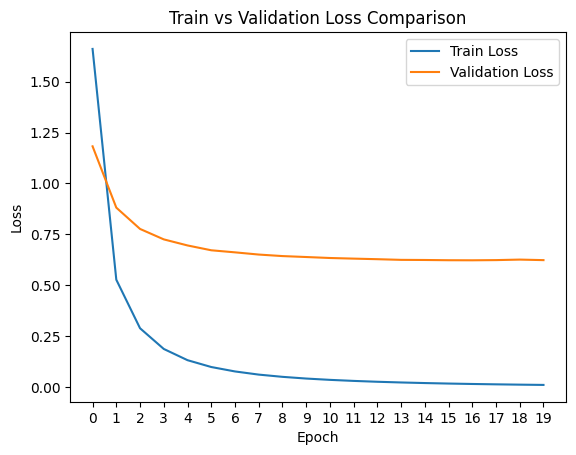

In [330]:
plt.title('Train vs Validation Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(range(MAX_EPOCHS))

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')

plt.legend()

plt.show()

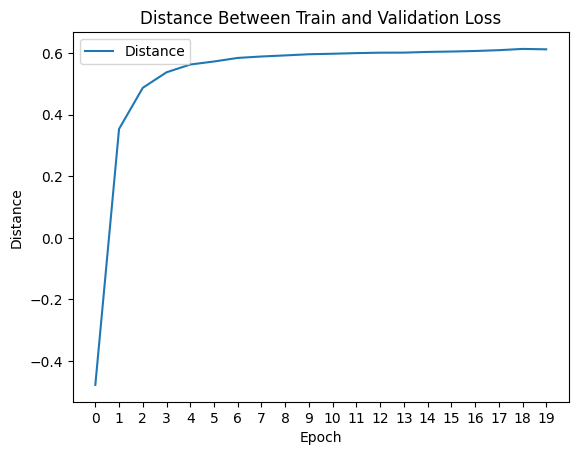

In [331]:
plt.title('Distance Between Train and Validation Loss')
plt.ylabel('Distance')
plt.xlabel('Epoch')
plt.xticks(range(MAX_EPOCHS))

plt.plot(diffs, label='Distance')

plt.legend()
plt.show()

# Final verdict: Overfitting!

In [332]:
# We have overfitting. Model is not good.

train_loss = evaluate(model, train_dataset)
validation_loss = evaluate(model, test_dataset)

print("Training datset", train_loss)
print("Test datset", validation_loss)

Training datset 0.008461682785699445
Test datset 0.6238549353353464
